# Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [175]:
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import re

## 2. Verifying laws of software evolution

In [176]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '/home/william/Desktop/eucalyptus'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [177]:
# Your code here
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
tags_list = list(line.strip().decode("utf-8") for line in process.stdout)
print(tags_list)


['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1.1', 'v4.3.1', 'v4.3.0.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', 'karmic', 'jaunty', 'ha-baseline', '3.4.2', '3.4.1', '3.4.0', '3.3-m6', '3.3-m5', '3.3-m4', '3.3-m3', '3.3-m2', '3.3-m1', '3.3.2', '3.3.1', '3.3.0.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1-beta1', '3.1-alpha2', '3.1.2', '3.1.1', '3.1.0', '3.0-rc3', '3.0-rc2', '3.0-rc1', '3.0-beta6', '3.0-beta5', '3.0-beta4', '3.0-beta3', '3.0-beta2', '3.0-alpha1', '3.0.1', '3.0.0', '2.0-branch', '2.0-beta', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0', '1.4', '1.0-beta']


In [178]:
# Your tag filtering code here
tags = []
for t in tags_list:
    a = re.fullmatch("v*[0-9]\.[0-9]\.[0-9]", t)
    if a != None:
        tags.append(a[0])
    else:
        a = re.fullmatch("v*[0-9]\.[0-9]",t)
        if a != None:
            tags.append(a[0])
print(tags)

['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', '3.4.2', '3.4.1', '3.4.0', '3.3.2', '3.3.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1.2', '3.1.1', '3.1.0', '3.0.1', '3.0.0', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0', '1.4']


In [179]:
major_minor_patch_versions = ['1.4','1.5.0','1.5.1','1.5.2','1.6.1','2.0.0','2.0.1','3.0.0','3.0.1','3.1.0','3.1.1','3.1.2','3.2.0','3.2.1',
                              '3.2.2','3.3.0','3.3.1','3.3.2','3.4.0','3.4.1','3.4.2','v4.0.0','v4.0.1','v4.0.2','v4.1.0','v4.1.1','v4.1.2',
                              'v4.2.0','v4.2.1','v4.2.2','v4.3.0','v4.3.1','v4.4.0','v4.4.1','v4.4.2']
major_minor_versions = ['1.4','1.5.0','1.6.1','2.0.0','3.0.0','3.1.0','3.2.0','3.3.0','3.4.0','v4.0.0','v4.1.0','v4.2.0','v4.3.0','v4.4.0']

### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [180]:
#Your code here    

m_m_p_versions_cloc = {'tag':[],'blank' : [], 'comment' :[], 'code' : [], 'nFiles' : []}
for tag in major_minor_patch_versions:
    # set project to a tag
    command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    # execute cloc
    command = f'cloc --git --json {eucalyptus_project_path}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    output = "".join(list(line.strip().decode("utf-8") for line in process.stdout))
    # get lines of code, blank lines, comment lines and number of lines
    data = json.loads(output)['SUM']
    # add the data to the dictionnary
    m_m_p_versions_cloc['tag'].append(tag)
    for i in data:
        m_m_p_versions_cloc[i].append(data[i])

# convert the dictionnary to a dataframe
df = pd.DataFrame.from_dict(m_m_p_versions_cloc)
df.head()
    


Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.

1 error:
Line count, exceeded timeout:  /home/william/Desktop/eucalyptus/net/globalnetwork.c


,tag,blank,comment,code,nFiles
0,1.4,8698,10969,48486,416
1,1.5.0,10983,18268,63151,507
2,1.5.1,11599,18074,67920,597
3,1.5.2,11538,11913,68655,609
4,1.6.1,14549,41303,86742,740


In [181]:
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r' # to get the release date
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
# Your code to obtain the release date of each tag and combine it with the data obtained in the previous cell. Final data should have
# #lines of code, #comments, #files, #blanks, #release date

# add release_date columns
df['release_date'] = ''

output = list(line.strip().decode("utf-8") for line in process.stdout)
for line in output:
    data = line.split('|')
    # add the date on the correct row in the dataframe
    df.loc[df['tag'] == data[0] , ['release_date']] = data[1]

df.head()

,tag,blank,comment,code,nFiles,release_date
0,1.4,8698,10969,48486,416,2009-01-06
1,1.5.0,10983,18268,63151,507,2009-02-18
2,1.5.1,11599,18074,67920,597,2009-08-05
3,1.5.2,11538,11913,68655,609,2009-08-17
4,1.6.1,14549,41303,86742,740,2009-11-05


In [182]:
# Your code here to get the versions of the form major.minor 
df_major_minor = pd.read_csv("/home/william/Desktop/Software_evolution_TP2_2023/LIG_major_minor.csv")
df_major_minor.head()

,Unnamed: 0,major,minor,nb_code,nb_blank,nb_comment,nb_nfiles,date,relative_day,major.minor
0,0,1,4,115336,18033,37569,1624,2009-01-06,0,1.4
1,1,1,5,129319,20261,44820,1705,2009-02-18,43,1.5
2,2,1,6,152705,23755,65761,1923,2009-11-05,303,1.6
3,3,2,0,181316,27549,67567,2251,2010-06-05,515,2.0
4,4,3,0,255305,39181,87179,2894,2012-02-07,1127,3.0


In [183]:
# Your code here to get the versions of the form major.minor.patch

df_major_minor_patch = pd.read_csv("/home/william/Desktop/Software_evolution_TP2_2023/LIG_major_minor_patch.csv")
df_major_minor_patch.head()

,Unnamed: 0,major,minor,patch,nb_code,nb_blank,nb_comment,nb_nfiles,date,relative_day,major.minor.patch
0,0,1,4,0,115336,18033,37569,1624,2009-01-06,0,1.4.0
1,1,1,5,0,129319,20261,44820,1705,2009-02-18,43,1.5.0
2,2,1,5,1,133424,20780,44377,1784,2009-08-05,211,1.5.1
3,3,1,5,2,134275,20719,38184,1796,2009-08-17,223,1.5.2
4,4,1,6,1,152705,23755,65761,1923,2009-11-05,303,1.6.1


#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

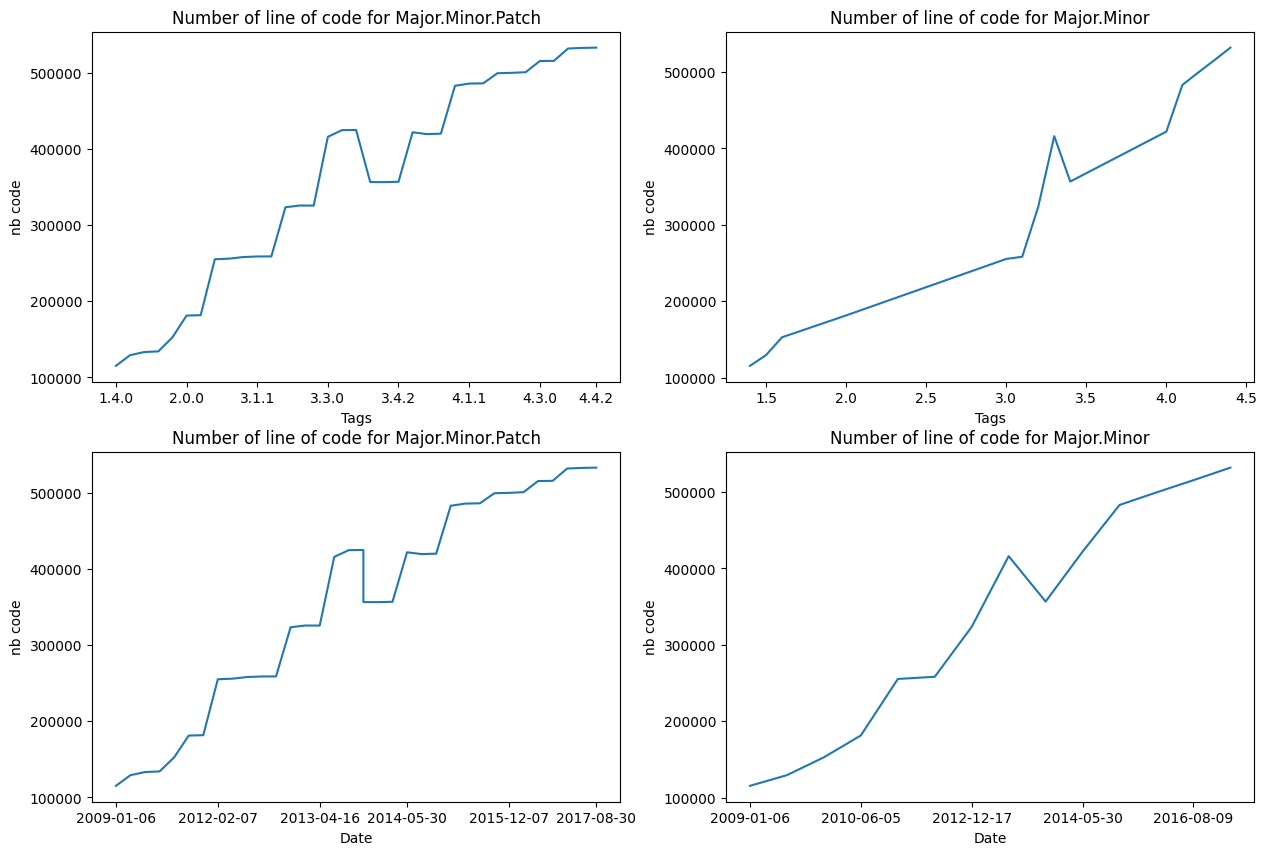

In [184]:
fig,axes = plt.subplots(2,2,figsize=(15, 10))
# Your plotting code here

# 1 i)
x1 = df_major_minor_patch.get("major.minor.patch")
y1 = df_major_minor_patch.get("nb_code")
axes[0,0].plot(x1,y1)
axes[0,0].set_title("Number of line of code for Major.Minor.Patch")
axes[0,0].set_ylabel("nb code")
axes[0,0].set_xlabel("Tags")
t1 = x1.to_numpy()
axes[0,0].set_xticks(t1[[0,5,10,15,20,25,30,34]])

#1 ii)
x2 = df_major_minor.get("major.minor")
y2 = df_major_minor.get("nb_code")
axes[0,1].plot(x2,y2)
axes[0,1].set_title("Number of line of code for Major.Minor")
axes[0,1].set_ylabel("nb code")
axes[0,1].set_xlabel("Tags")


#2 i)
x3 = df_major_minor_patch.get("date")
y3 = df_major_minor_patch.get("nb_code")
axes[1,0].plot(x3,y3)
axes[1,0].set_title("Number of line of code for Major.Minor.Patch")
axes[1,0].set_ylabel("nb code")
axes[1,0].set_xlabel("Date")
t3 = x3.to_numpy()
axes[1,0].set_xticks(t3[[0,7,14,21,28,34]])

#2 ii)
x4 = df_major_minor.get("date")
y4 = df_major_minor.get("nb_code")
axes[1,1].plot(x4,y4)
axes[1,1].set_title("Number of line of code for Major.Minor")
axes[1,1].set_ylabel("nb code")
axes[1,1].set_xlabel("Date")
t4 = x4.to_numpy()
axes[1,1].set_xticks(t4[[0,3,6,9,12]])
plt.show()

### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

For the tags of type major.minor.patch, we observe that the plot is the same.

For the tags of the major.minor, we observe that the plot is different. It has the same shape but the length of the line between two point is different.


2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

It is preferable to use the tag in the x-axis because the tag gives us what type of realease it was. We can see if it is a major release, a minor release or a patch release.

3. Choose an option regarding the growth of the software by considering Dataset A. Motivate your choice using a 1d regression plot (below).  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

The growth seem to be linear. 

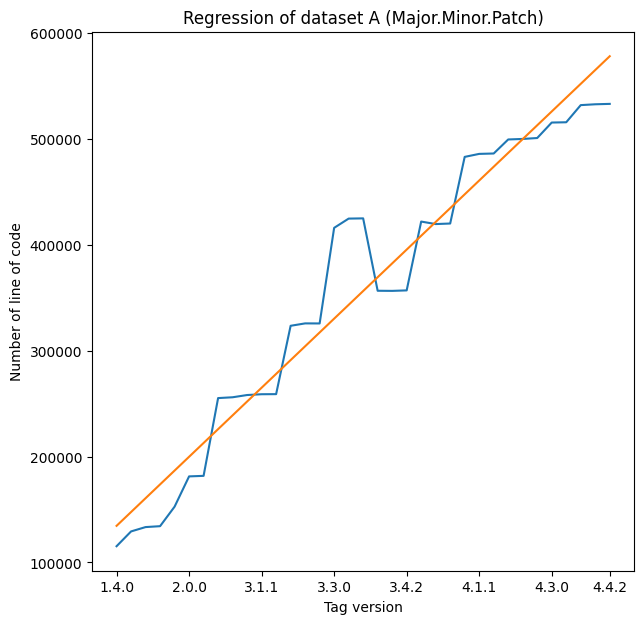

In [185]:
plt.figure(figsize=(7,7))
# Your code for regression plot
lin = LinearRegression()
X = np.arange(len(x1)).reshape(-1, 1)
lin.fit(X,y1)
Y = lin.predict(X)
plt.plot(x1,y1)
plt.plot(x1,Y)
plt.title("Regression of dataset A (Major.Minor.Patch)")
plt.xlabel("Tag version")
plt.ylabel("Number of line of code")
plt.xticks(t1[[0,5,10,15,20,25,30,34]])
plt.show()

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [186]:
# Your code for correlation
from scipy.stats import spearmanr, pearsonr

nb_code = df_major_minor_patch.get("nb_code")
nb_file = df_major_minor_patch.get("nb_nfiles")
res_spearman , p1 = spearmanr(nb_code ,nb_file )
print(f'Spearman correlation value : {res_spearman : .3f}')
res_pearson , p2= pearsonr(nb_code ,nb_file)
print(f'Pearson correlation value : {res_pearson : .3f}')

Spearman correlation value :  0.977
Pearson correlation value :  0.993


### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

We observe that the Pearson value is higher.

5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

The number of lines of code is highly correlated to the number of file since the correlation value is almost 1

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

In [187]:
# Your code here
dataset_A = df_major_minor_patch[:-2]
dataset_A.tail()


,Unnamed: 0,major,minor,patch,nb_code,nb_blank,nb_comment,nb_nfiles,date,relative_day,major.minor.patch
28,28,4,2,1,500161,79043,234453,4296,2015-12-07,2526,4.2.1
29,29,4,2,2,501035,79137,234639,4299,2016-04-27,2668,4.2.2
30,30,4,3,0,515659,79336,233230,4198,2016-08-09,2772,4.3.0
31,31,4,3,1,515924,79361,233247,4196,2016-12-14,2899,4.3.1
32,32,4,4,0,532121,82317,229918,4378,2017-03-07,2982,4.4.0


In [188]:
# Your code here
model = LinearRegression()
X = np.arange(len(dataset_A.get("major.minor.patch"))).reshape(-1, 1)
Y = dataset_A.get("nb_code")
model.fit(X,Y)
print(model.coef_)

[13505.60093583]


In [189]:
# Your code here
X_pred = np.arange(len(Y)+2).reshape(-1, 1)
y_pred = model.predict(X_pred)

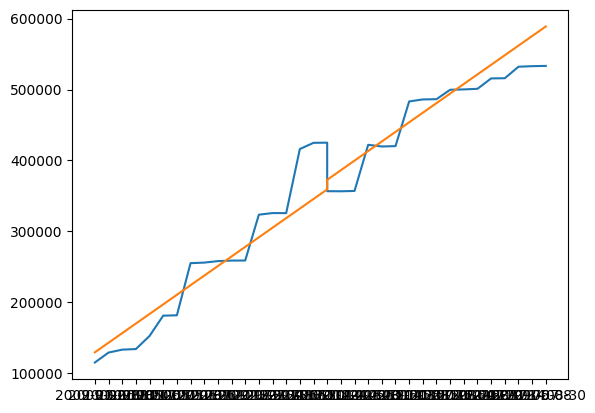

In [190]:
# Your plotting code here
dates = df_major_minor_patch.get("date")
nb_code = df_major_minor_patch.get("nb_code")
plt.plot(dates,nb_code)
plt.plot(dates,y_pred)

### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

Since the evolution looks like to be linear, the model uses a polynomial degree of 1

7. What is the coefficient of determination? (R-squared)

In [191]:
from sklearn.metrics import r2_score

y_true = df_major_minor_patch.get("nb_code")
score = r2_score(y_true,y_pred)
print(score)

0.9416882302527566


The coefficient of determination is 0.942

8. What is the Root mean square error for the forecasted values?

In [192]:
from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_true, y_pred, squared=False)
print(score)

32771.795622385944


### Filtering on coding langugage

Consider the prominent langugages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

In [193]:
# Your code to get the data for LOC of first and last versions

first_version = '1.4'
last_version = 'v4.4.2'


def getLOC(tag):
    command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    command = f'cloc --git --json {eucalyptus_project_path}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    output = ''.join(list(line.strip().decode("utf-8") for line in process.stdout))
    data = json.loads(output)
    lang_loc = {}
    for i in data:
        if (i != "header") and (i != "diff") and (i != "SUM"):
            lang_loc[i] = data[i]['code']
    return lang_loc


first_lang_loc = getLOC(first_version)
last_lang_loc = getLOC(last_version)
print("The 5 prominet language of the first version")
for l in list(first_lang_loc)[:5]:
    print(f'{l} : {first_lang_loc[l]}')

print("\nThe 5 prominet language of the last version")
for l in list(last_lang_loc)[:5]:
    print(f'{l} : {last_lang_loc[l]}')


The 5 prominet language of the first version
Java : 21281
Bourne Shell : 9866
C : 8914
XML : 3113
Groovy : 1766

The 5 prominet language of the last version
Java : 174502
Groovy : 32486
C : 20580
XML : 17157
Bourne Shell : 7580


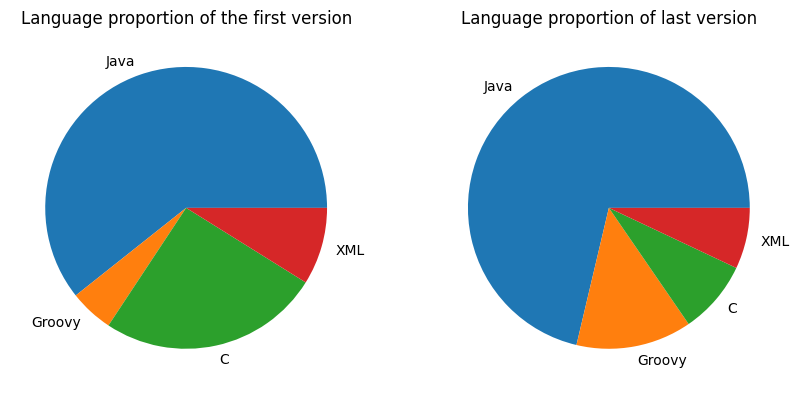

In [194]:
# Your pie chart code here

prominent_lang = ["Java", "Groovy","C","XML"]
y_first = []
for l in prominent_lang:
    y_first.append(first_lang_loc[l])


y_last = []
for l in prominent_lang:
    y_last.append(last_lang_loc[l])

fig, ax = plt.subplots(1,2,figsize=(10, 10))
ax[0].pie(y_first, labels=prominent_lang )
ax[0].set_title("Language proportion of the first version")
ax[1].pie(y_last,labels=prominent_lang )
ax[1].set_title("Language proportion of last version")

plt.show()

### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

We observe that the language the have increase in term of proportion are Java and Groovy. We also observe that the proportion of C code has decreased and the proportion of XML code doesn't seem to have change. 

### Law of increasing growth for coding langugages

Get the LOC for each of the considered prominent langugages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.
Use of uninitialized value in concatenation (.) or string at /bin/cloc line 5946.

1 error:
Line count, exceeded timeout:  /home/william/Desktop/eucalyptus/net/globalnetwork.c


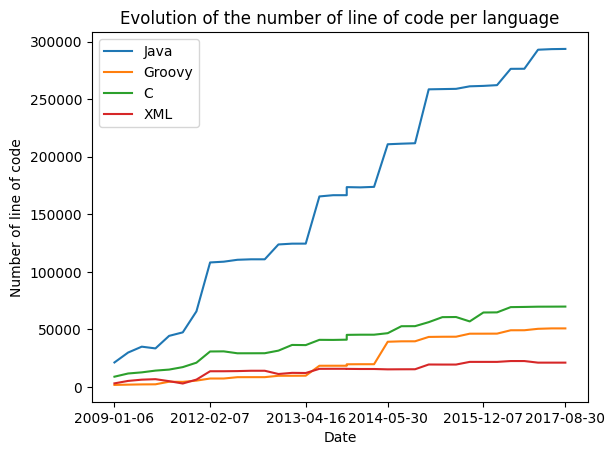

In [195]:
# Your code to get the LOC for each prominent language of each version
def get_LOC_prominent_tag(tag, prominent_lang):
    lang_loc = getLOC(tag)
    loc_pro_tag = []
    for l in prominent_lang:
        loc_pro_tag.append(lang_loc[l])
    return loc_pro_tag

loc_lang_tags = {}
for l in prominent_lang:
    loc_lang_tags[l] = []


for tag in major_minor_patch_versions:
    loc = get_LOC_prominent_tag(tag,prominent_lang)
    for i in range(len(prominent_lang)):
        lang = prominent_lang[i]
        loc_lang_tags[lang].append(loc[i])


date = df_major_minor_patch.get('date')
for l in prominent_lang:
    y = loc_lang_tags[l]
    plt.plot(date,y,label=l)

plt.xlabel("Date")
plt.ylabel("Number of line of code")
plt.title("Evolution of the number of line of code per language")
plt.xticks(t3[[0,7,14,21,28,34]])
plt.legend()
plt.show()

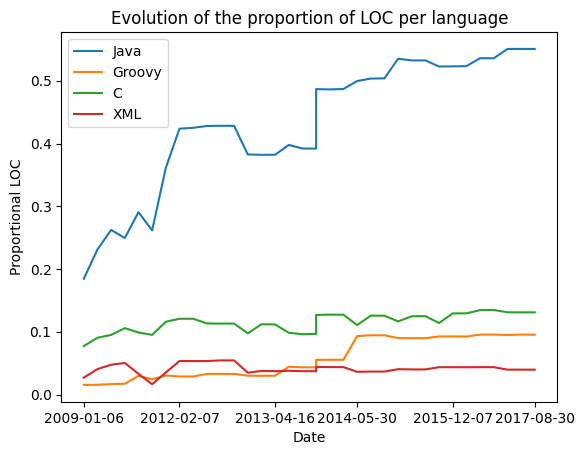

In [196]:
# Your plotting code here
total_loc = df_major_minor_patch.get("nb_code")
for l in prominent_lang:
    y = np.array(loc_lang_tags[l]) / total_loc
    plt.plot(date,y,label=l)

plt.xlabel("Date")
plt.ylabel("Proportional LOC")
plt.title("Evolution of the proportion of LOC per language")
plt.xticks(t3[[0,7,14,21,28,34]])
plt.legend()
plt.show()

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

11. Does this software project obey the Law of Increasing Growth?

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

In [197]:
# Your code and plot here

2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

In [198]:
# Your code and plot here

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

In [199]:
# Your code and plot here

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:  
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.  
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [200]:
eucalyptus_project_path = '' # your project path here
eucalyptus_copy_project_path = '' # your path to the copy of your project here
major_minor_patch_versions = '' #set of version that you would like to consider for this analysis

In [201]:
# Your code here to get the data

In [202]:
# Your code here to get the dates corresponding to the tags

In [203]:
# Your plotting code here (all the features in a single plot)

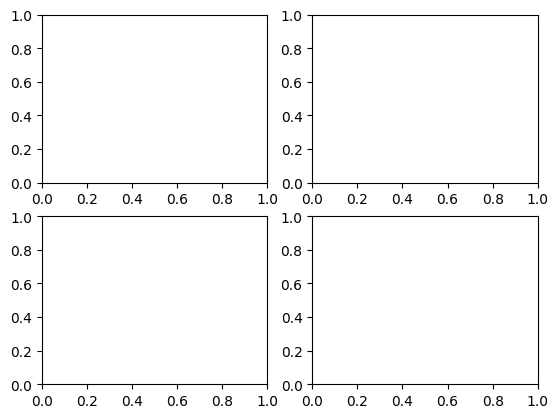

In [204]:
# Your plotting code here, different plot for each feature
fig,axes = plt.subplots(2,2)

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

2. Does the law of increasing growth too hold good here?

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis  
    a) y-axis number of lines of code   
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code) 

In [205]:
# Your code here

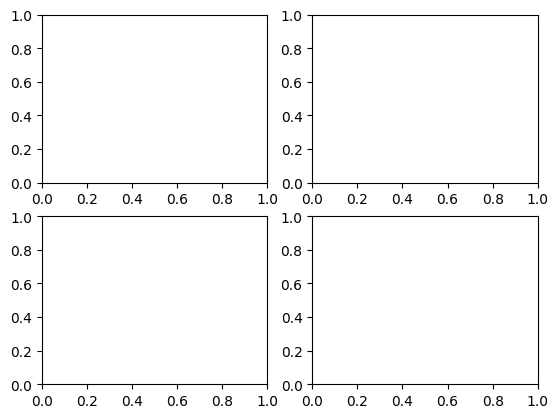

In [206]:
# Your plotting code here
fig,axes = plt.subplots(2,2)

### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.  

4. Does this software project obey Law of Continuing Change?